In [9]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('default')     #switch betweeb 'default' and 'ignore'

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

# Load Data

## Establish DB connection

In [2]:
import findspark
findspark.init('/opt/spark/spark-3.2.1-bin-hadoop3.2')
from pyspark.sql import SparkSession

# the Spark session should be instantiated as follows
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.jars", "/opt/spark/spark-3.2.1-bin-hadoop3.2/jars/postgresql-42.3.5.jar") \
    .getOrCreate()
#    .config("spark.jars", "postgresql-42.2.10-1.jar") \
print("Connection complete!")

22/06/03 17:10:52 WARN Utils: Your hostname, AMDFX8520 resolves to a loopback address: 127.0.1.1; using 192.168.1.51 instead (on interface enp2s0)
22/06/03 17:10:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/06/03 17:10:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/03 17:10:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Connection complete!


## Load and View Schema

In [3]:
customSchema = "_issuefix_bkdata"
print("Wait a moment, retrieving data ...")
booking_df = spark.read.format("jdbc") \
    .option("url", "jdbc:postgresql://10.11.34.33:5432/Datascience") \
    .option("dbtable", "_issuefix_bkdata.reservations") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .load()
print("Loaded schema")
booking_df.printSchema()
print("Loading complete!")

Wait a moment, retrieving data ...
Loaded schema
root
 |-- vendor_uuid: string (nullable = true)
 |-- agent_name: string (nullable = true)
 |-- hotel_uuid: string (nullable = true)
 |-- hotel_name: string (nullable = true)
 |-- reserved_status: string (nullable = true)
 |-- reserved_datetime: string (nullable = true)
 |-- booking_for_datetime: date (nullable = true)
 |-- reserved_for_datetime: date (nullable = true)
 |-- check_in_date: date (nullable = true)
 |-- check_out_date: date (nullable = true)
 |-- number_of_nights: integer (nullable = true)
 |-- number_of_rooms: integer (nullable = true)
 |-- booking_type: string (nullable = true)
 |-- agent_booking_currency: string (nullable = true)
 |-- agent_daily_rate: double (nullable = true)
 |-- agent_total_cost: double (nullable = true)
 |-- hotel_currency: string (nullable = true)
 |-- hotel_daily_rate: float (nullable = true)
 |-- group_booking_type: string (nullable = true)

Loading complete!


## Remove unnecessary columns

In [4]:
print("Wait a moment ...")
booking_df=booking_df.drop("vendor_uuid",
                           "agent_name",
                           "hotel_uuid",
                           "reserved_status",
                           "booking_for_datetime",
                           "booking_type",
                           "agent_booking_currency",
                           "hotel_currency",
                           "hotel_daily_rate",
                           "group_booking_type")
print("Remaining columns\n",booking_df.printSchema())

Wait a moment ...
root
 |-- hotel_name: string (nullable = true)
 |-- reserved_datetime: string (nullable = true)
 |-- reserved_for_datetime: date (nullable = true)
 |-- check_in_date: date (nullable = true)
 |-- check_out_date: date (nullable = true)
 |-- number_of_nights: integer (nullable = true)
 |-- number_of_rooms: integer (nullable = true)
 |-- agent_daily_rate: double (nullable = true)
 |-- agent_total_cost: double (nullable = true)

Remaining columns
 None


## Group by date
Group all data to create a single count or sum for each date value

In [5]:
import pandas as pd

print("Wait a moment ...")

_grp_book_collect = sorted(booking_df.groupby("check_in_date")
                           .sum("number_of_nights","number_of_rooms","agent_total_cost")
                           .collect())

''' Set data types and calculate the room nights '''
_grp_book_df = pd.DataFrame(list(zip(*_grp_book_collect))).T
_grp_book_df = _grp_book_df.rename(columns={0 : 'Date', 1 : 'Nights', 2 : 'Rooms', 3 : 'AgentCost'})
_grp_book_df['Date'] = _grp_book_df['Date'].astype('datetime64[ns]')
_grp_book_df['Nights'] = _grp_book_df['Nights'].astype('int64')
_grp_book_df['Rooms'] = _grp_book_df['Rooms'].astype('int64')
_grp_book_df['RoomNights'] = _grp_book_df['Nights'] * _grp_book_df['Rooms']
_grp_book_df['AgentCost'] = round(_grp_book_df['AgentCost'].astype('float64'),2)
_grp_book_df.info()
print("Grouping complete!")

Wait a moment ...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        822 non-null    datetime64[ns]
 1   Nights      822 non-null    int64         
 2   Rooms       822 non-null    int64         
 3   AgentCost   822 non-null    float64       
 4   RoomNights  822 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 32.2 KB
Grouping complete!


/usr/lib/python3.8/socket.py:740: ResourceWarning: unclosed <socket.socket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 34394), raddr=('127.0.0.1', 37825)>
  self._sock = None


## Enrich the dataset

### Declare DataEnricment class

In [15]:
import sys
sys.path.insert(1, '../wrangler')
import enrich as en

if debug:
    import importlib
    en = importlib.reload(en)

data_name = "travel_bookings"
cls_enrich = en.DataEnrichment(name=data_name)
print(dir(cls_enrich))
print(cls_enrich._aug_dict)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_dist_types', '_distributions', '_dup_method', '_l_dup_methods', 'count_duplicates', 'count_nulls', 'fit_distributions', 'get_central_tendency', 'get_data_types', 'name', 'test_uniformity']


### Augment with Date columns
For the ease of sorting and displaying the date value by month & day

In [7]:
col_to_augment_dict = {"DateTime" :   # type of datetime columns to augment the dataframe
                       ["YYYY",       # 4 digit year (int)
                        "DD",         # day as 1 digit and 2 digit if abbreviation = true
                        "MM",         # month as 1 digit and 2 digit if abbreviation = true
                        "MMM",        # month as name or 3 letters if abbreviation = True
                        "DOW",        # day-of-week name or 3 letter if abbreviation = True
                        "MMM-DD",     # three letter two digit month and two digit day (e.g. [09]Sep-10)
                       ]
                      }
_kwargs = {"dt_col_name" : "Date",    # identifies the datetime column in the dataframe
           "pad_lead_zeros" : True,   # truncates the string to give 3 character names for year, month, dow
           "abbreviate" : True,
           "sorted_by" : ["YYYY","MM","DD"]
          }
_enriched_df = cls_enrich.get_enriched_data(_grp_book_df,
                                            col_augment_dict = col_to_augment_dict,
                                            **_kwargs
                                   )
_aug_cols = col_to_augment_dict["DateTime"]
_grp_book_df[_aug_cols] = _enriched_df[_aug_cols]

''' sort by date '''
_grp_book_df = _grp_book_df.sort_values(by=["YYYY","MM","DD"],kind='quicksort')
_grp_book_df.to_csv("../data/bookings.csv", sep=',', index=False)
print(_grp_book_df.head())
print("\nEnrichment Complete!")

{'DateTime': ['YYYY', 'DD', 'MM', 'MMM', 'DOW', 'MMM-DD']}
        Date  Nights  Rooms  AgentCost  RoomNights  YYYY  DD  MM  MMM  DOW  \
0 2021-01-01     118     76   11404.17        8968  2021  01  01  Jan  Fri   
1 2021-01-02     182    126   18054.63       22932  2021  02  01  Jan  Sat   
2 2021-01-03     130     95   16075.45       12350  2021  03  01  Jan  Sun   
3 2021-01-04     128     77   13462.01        9856  2021  04  01  Jan  Mon   
4 2021-01-05     104     65   14490.60        6760  2021  05  01  Jan  Tue   

       MMM-DD  
0  [01]Jan-01  
1  [01]Jan-02  
2  [01]Jan-03  
3  [01]Jan-04  
4  [01]Jan-05  

Enrichment Complete!


## Time Series Decompositions
[Core components](https://towardsdatascience.com/advanced-time-series-analysis-in-python-decomposition-autocorrelation-115aa64f475e) of a time series - also discussed [here](https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621)
1. __Seasonality__ — does the data have a clear cyclical/periodic pattern?
1. __Trend__ — does the data represent a general upward or downward slope?
1. __Irregularity__ — also called noise, what are the outliers or missing values that are not consistent with the rest of the data?
1. __Cyclic__ — This is when a series is repeating upward and downward movement.

### Read data from CSV

In [15]:
import pandas as pd

_grp_book_df = pd.read_csv("../data/bookings.csv")

_grp_book_df['Date'] = _grp_book_df['Date'].astype('datetime64[ns]')
_grp_book_df['Nights'] = _grp_book_df['Nights'].astype('int64')
_grp_book_df['Rooms'] = _grp_book_df['Rooms'].astype('int64')
_grp_book_df['AgentCost'] = round(_grp_book_df['AgentCost'].astype('float64'),2)
_grp_book_df['RoomNights'] = _grp_book_df['Nights'] * _grp_book_df['Rooms']
_grp_book_df['YYYY'] = _grp_book_df['YYYY'].astype('int64')
_grp_book_df['DD'] = _grp_book_df['DD'].astype('string')
_grp_book_df['MM'] = _grp_book_df['MM'].astype('string')
_grp_book_df['MMM'] = _grp_book_df['MMM'].astype('string')
_grp_book_df['DOW'] = _grp_book_df['DOW'].astype('string')
_grp_book_df['MMM-DD'] = _grp_book_df['MMM-DD'].astype('string')
_grp_book_df.info()
print("Data load and type transformation complete!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        822 non-null    datetime64[ns]
 1   Nights      822 non-null    int64         
 2   Rooms       822 non-null    int64         
 3   AgentCost   822 non-null    float64       
 4   RoomNights  822 non-null    int64         
 5   YYYY        822 non-null    int64         
 6   DD          822 non-null    string        
 7   MM          822 non-null    string        
 8   MMM         822 non-null    string        
 9   DOW         822 non-null    string        
 10  MMM-DD      822 non-null    string        
dtypes: datetime64[ns](1), float64(1), int64(4), string(5)
memory usage: 70.8 KB
Data load and type transformation complete!


### Plot time series by year

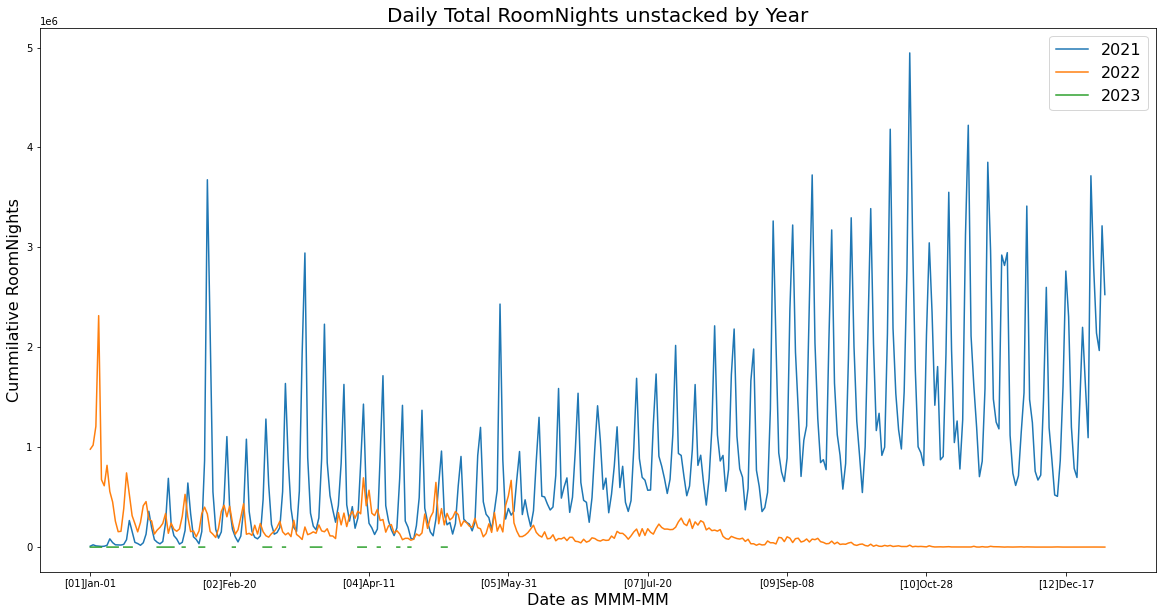

In [16]:
''' Plot the individual year time series'''

''' change y_var to view the desired time series '''
y_var = "RoomNights"   # set the dependent variable (e.g. RoomNights, AgentCost)

unstacked = _grp_book_df.set_index(['YYYY','MMM-DD'])[y_var].unstack(-2)
ax = unstacked.plot(figsize=(20, 10),
                    fontsize=10)
ax.set_title("Daily Total "+y_var+" unstacked by Year", fontsize=20)
ax.set_xlabel("Date as MMM-MM",fontsize=16)
ax.set_ylabel("Cummilative "+y_var, fontsize=16)
ax.legend(fontsize=16)

### Seasonality, Trend, Irregulairyt analysis
Check if time series is stationary using [KPSS test](https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/)

Testing if time series is stationary
mean1 = 410217.715625, mean2 = 693683.784000
variance1 = 11410398020.390215, variance2 = 45243265318.508347


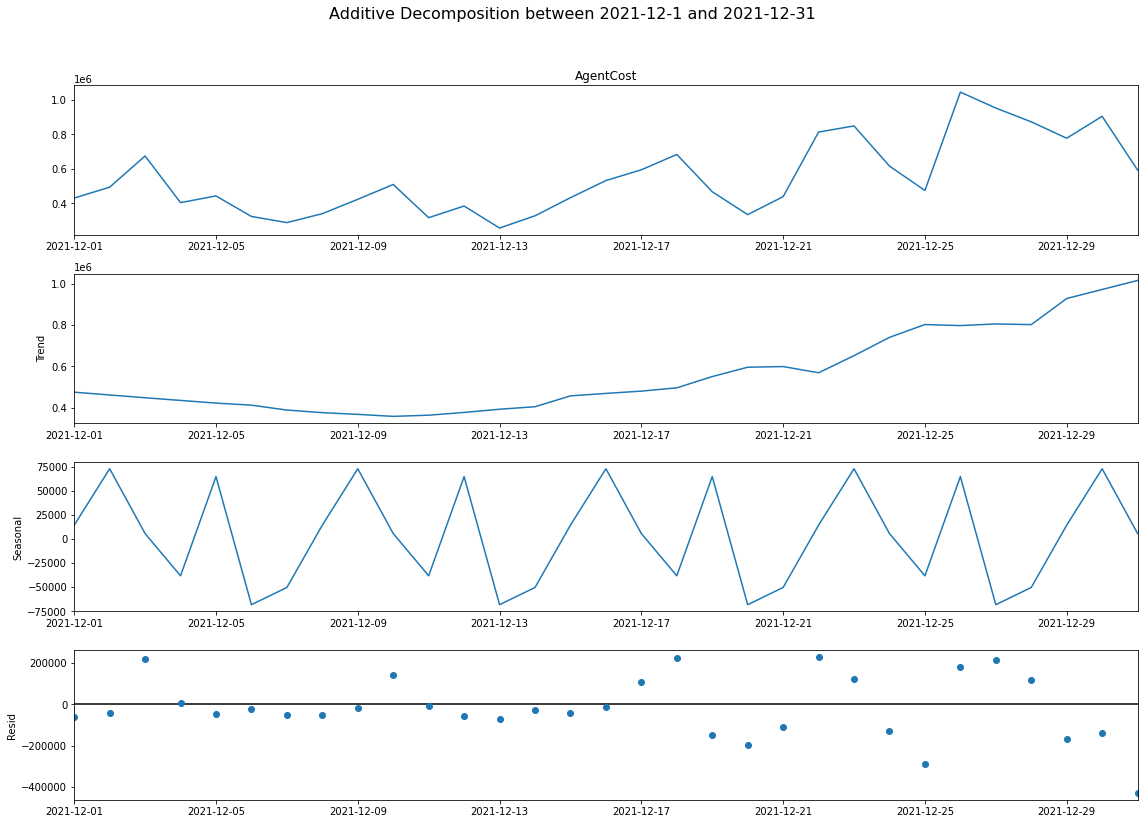

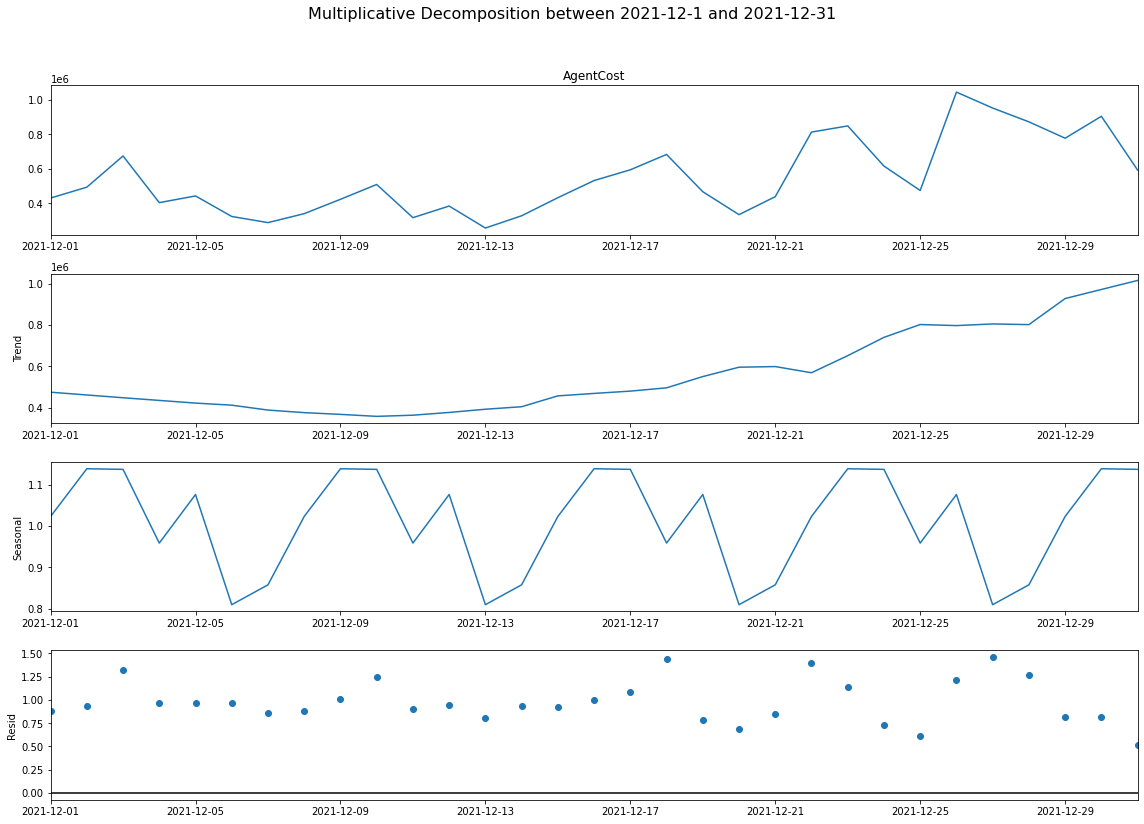

In [17]:
import statsmodels.api as sm
from matplotlib import rcParams
import matplotlib.pyplot as plt

''' change y_var to view the desired time series '''
_str_y_var = "AgentCost"   # set the dependent variable (e.g. RoomNights, AgentCost)
_int_period = 7

start_date = "2021-12-1"
end_date = "2021-12-31"
_ts_ds = _grp_book_df.loc[_grp_book_df["Date"].between(start_date, end_date)]
_ts_ds = _ts_ds[["Date",_str_y_var]]

''' check if the time period is stationary '''
print("Testing if time series is stationary")
split = round(_ts_ds.shape[0] / 2)
X1, X2 = _ts_ds[_str_y_var][0:split], _ts_ds[_str_y_var][split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1 = %f, mean2 = %f' % (mean1, mean2))
print('variance1 = %f, variance2 = %f' % (var1, var2))

_ts_ds["Date"] = pd.to_datetime(_ts_ds["Date"])
tdi = pd.DatetimeIndex(_ts_ds.Date)
_ts_ds.set_index(tdi, inplace=True)
_ts_ds.drop(columns='Date', inplace=True)
_ts_ds.index.name = 'Date Range'

additive_decomposition = sm.tsa.seasonal_decompose(x=_ts_ds[_str_y_var],
                                                   model = 'additive',
                                                   extrapolate_trend='freq',
                                                   period=_int_period)
multiplicative_decomposition = sm.tsa.seasonal_decompose(x=_ts_ds[_str_y_var],
                                                   model = 'multiplicative',
                                                   extrapolate_trend='freq',
                                                   period=_int_period)

''' Plot - to view a single component: seasonal, trend, resid, etc
    use <*_decomposition.seasonal.plot(*)> replace * with appropriate parameters '''
plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition.plot().suptitle("Additive Decomposition between "+start_date+" and "+end_date,
                                       fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

multiplicative_decomposition.plot().suptitle("Multiplicative Decomposition between "+start_date+" and "+end_date,
                                             fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Autocorrelation
While autocorrelation is useful for analyzing a time series's properties and choosing what type of ARIMA model to use, partial autocorrelation tells what order of autoregressive model to fit.

/home/gnewy/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


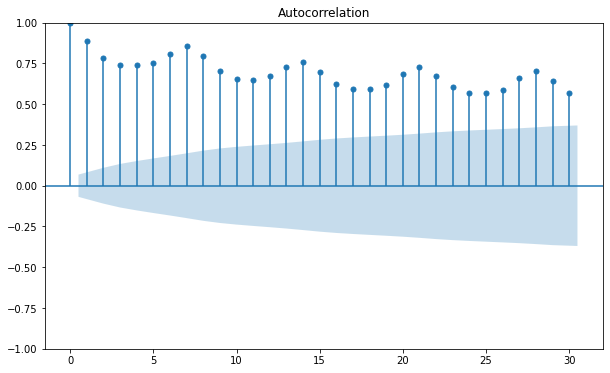

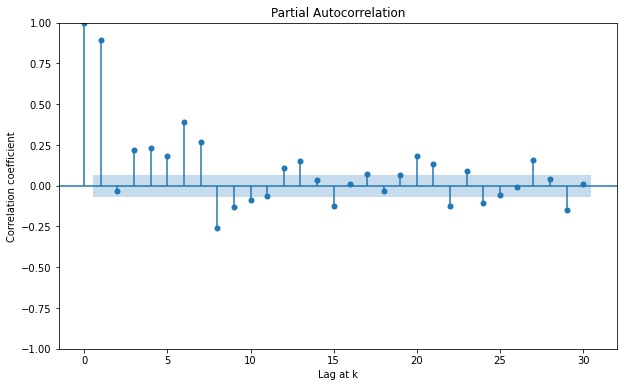

In [18]:
from statsmodels.graphics import tsaplots
from matplotlib import rcParams
import matplotlib.pyplot as plt

rcParams["figure.figsize"] = 10, 6

# Stands for Time Series Analysis Plots (TSA Plots)
fig = tsaplots.plot_acf(_grp_book_df["AgentCost"], lags=30)
fig = tsaplots.plot_pacf(_grp_book_df["AgentCost"], lags=30)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

In [19]:
corr_df = _grp_book_df.copy(["Nights","Rooms","AgentCost"]).reset_index(drop=True)
corr_df.corr(method='pearson', min_periods=1)

,Nights,Rooms,AgentCost,RoomNights,YYYY
Nights,1.000000,0.967888,0.953989,0.912744,-0.671341
Rooms,0.967888,1.000000,0.898120,0.941270,-0.696656
AgentCost,0.953989,0.898120,1.000000,0.862823,-0.573855
RoomNights,0.912744,0.941270,0.862823,1.000000,-0.529604
YYYY,-0.671341,-0.696656,-0.573855,-0.529604,1.000000


# Time Series Evaluations
We want to know if there is an association between _ _ _ _ _ for the current 7-day window and the baseline 7-day window
1. number of nights * number of rooms and the booking value
* Null Hypothesis H<sub>0</sub>: number of nights * number of rooms and the booking value are independent
* Alternative Hypothesis H<sub>A</sub>: number of nights * number of rooms and the booking value are no independent

If H<sub>1</sub> with P_value > 0.05 implies there is an anomaly in that particular 7-day window

Apply the
* [Fisher Exact Test](https://www.statology.org/fishers-exact-test-python/)
* Differnce and Raio
* Autocorrelation
* ARIMA F-test
* Random Walk model - widely used for non-stationary data, particularly financial and economic data. Random walks typically have: long periods of apparent trends up or down sudden and unpredictable changes in direction. The forecasts from a random walk model are equal to the last observation, as future movements are unpredictable, and are equally likely to be up or down.


In [20]:
import datetime
from datetime import timedelta, date

#for yr_idx, yr_val in enumerate(sorted(_grp_book_df["YYYY"].unique(),reverse=False)):
#    print(yr_idx,yr_val)
    
base_yr = 2021
curr_yr = 2022
months = "01"
#base_df = _grp_book_df.loc[(_grp_book_df['YYYY'] == base_yr) & (_grp_book_df['MM'] == months)]
base_df = _grp_book_df.loc[_grp_book_df['YYYY'] == base_yr]
#curr_df = _grp_book_df.loc[(_grp_book_df['YYYY'] == curr_yr) & (_grp_book_df['MM'] == months)]
curr_df = _grp_book_df.loc[_grp_book_df['YYYY'] == curr_yr]
print("%d rows of baseline and %d of post-baseline (current) data ready"
      % (base_df.shape[0], curr_df.shape[0]))

''' init the 7-day sliding window '''
day_offset = 0  # start at first day
win_length = 7 # days

365 rows of baseline and 365 of post-baseline (current) data ready


In [21]:
import sys
sys.path.insert(1, '../ts')
import evaluation as ts_eval

if debug:
    import importlib
    ts_eval = importlib.reload(ts_eval)

data_name = "travel_bookings"
cls_ts_eval = ts_eval.TSEvaluation(name=data_name)
print(dir(cls_ts_eval))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'days_offset', 'evaluation_methods', 'get_fisher_exact', 'get_ts_eval_stats', 'name', 'p_val', 'window_length']


### Fisher-exact test

In [22]:
_counts_col = "RoomNights"
_eval_method = "fisher-exact-test"
#base_yr = 2021
#curr_yr = 2022
_args = {"days_offset" : 0,       # number of days to offset the begining of first window
         "window_length" : 7,     # sliding window length
         "p_val_cutoff" : 0.05,   # return only results with p-value < the cutoff
        }

#df = cls_ts_eval.get_ts_eval_stats(_grp_book_df[["Date","YYYY",counts_col]],base_yr,curr_yr)

df = pd.DataFrame([])
print("Wait a moment while we run the %s ... this will take a while" % _eval_method)
df = cls_ts_eval.get_ts_eval_stats(base_df,
                                   curr_df,
                                   counts_col=_counts_col,
                                   eval_meth=_eval_method,
                                   eval_params=_args)
#print(df)
print("%s completed and produced %d results with p-value < %f statistically significance"
      % (_eval_method, df.shape[0], _args["p_val_cutoff"]))

Wait a moment while we run the fisher-exact-test ... this will take a while
fisher-exact-test completed and produced 358 results with p-value < 0.050000 statistically significance


## Differencing the Time Series
Apply the differencing to a single time series with a lag.

<AxesSubplot:>

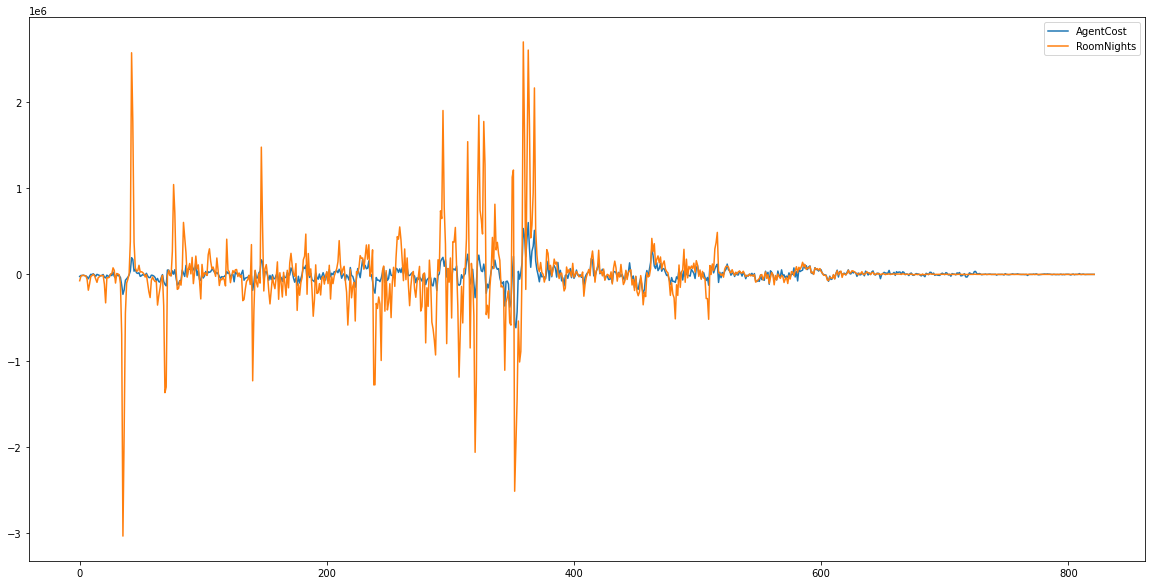

In [28]:
import pandas as pd

_one_ts_diff = pd.DataFrame([])
_one_ts_diff = _grp_book_df[["AgentCost","RoomNights"]].diff(periods=-7).fillna(0,inplace=False)
_one_ts_diff.plot(figsize=(20, 10),
                  fontsize=10)

## Differences and Ratios Current vs Baseline
Here the difference calculated is the difference between the corresponding dates of the baseline time series and the current time series

In [24]:
import numpy as np

_dual_ts_diff_df = pd.DataFrame([],columns=["Difference","Ratio"])
_l_base_roomNights = list(base_inner_df["RoomNights"])
_l_curr_roomNights = list(curr_inner_df["RoomNights"])
_l_diff = [i - j for i, j in zip(_l_curr_roomNights, _l_base_roomNights)]
_dual_ts_diff_df["Difference"] = _l_diff
_l_ratio = [i / j for i, j in zip(_l_curr_roomNights, _l_base_roomNights)]
_dual_ts_diff_df["Ratio"]=_l_ratio
#_dual_ts_diff_df

NameError: name 'base_inner_df' is not defined

### Granger causality test
[Grangertest](https://www.statology.org/granger-causality-test-in-python/) - used to determine whether or not one time series is useful for forecasting another.
* Null Hypothesis $H_{0}$: For a given time ($t_{0}$,$t_{k}$) window, time series from a period _T-1_ (e.g. 2020) does not Granger-cause time series from period _T_ (e.g. 2021) - i.e., F test statistic with a corresponding p-value 1-$\alpha$ $\le$ 0.05
* Alternative Hypothesis $H_{A}$: For a given time ($t_{0}$,$t_{k}$) window, time series from a period _T-1_ (e.g. 2020) Granger-cause time series from period _T_ (e.g. 2021) - i.e., F test statistic with a corresponding p-value $\alpha$ $\le$ 0.05

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests

print(base_inner_df.shape)
print(curr_inner_df.shape)
columns=['Base','Current']
_l_base = list(base_inner_df['RoomNights'])
_l_curr = list(curr_inner_df['RoomNights'])
df_gct=pd.DataFrame(data=[],columns=columns)
df_gct["Base"]=_l_base
df_gct["Current"]=_l_curr

_granger_dict=grangercausalitytests(df_gct[['Base','Current']], maxlag=[3])
_granger_dict.keys()

(20, 11)
(20, 11)

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6947  , p=0.5760  , df_denom=10, df_num=3
ssr based chi2 test:   chi2=3.5432  , p=0.3152  , df=3
likelihood ratio test: chi2=3.2184  , p=0.3592  , df=3
parameter F test:         F=0.6947  , p=0.5760  , df_denom=10, df_num=3


dict_keys([3])

In [18]:
_grp_book_df["20DaySMA"] = _grp_book_df['RoomNights'].rolling(window =100).mean()
_grp_book_df["20DaySMA"].fillna(0, inplace=True)
_grp_book_df["20DaySMA"]

0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
       ...  
817    86.66
818    86.62
819    86.49
820    81.34
821    71.09
Name: 20DaySMA, Length: 822, dtype: float64

## Select specific columns

In [19]:
jdbcDF.createOrReplaceTempView("resconfirmsv_df")
df2 = spark.sql("SELECT hotelcode, checkindate, checkoutdate FROM resconfirmsv_df WHERE checkindate='2021-09-17'")
df2.show()

NameError: name 'jdbcDF' is not defined

## Where are they from where are they going

In [ ]:
spark_df = spark.read.format("jdbc"). \
options(
    url='jdbc:postgresql://10.11.34.33:5432/Datascience', # jdbc:postgresql://<host>:<port>/<database>
    dbtable='_issuefix_bkdata.customerbookings',
    user='postgres',
    password='postgres',
    driver='org.postgresql.Driver').\
load()

In [20]:
import pandas as pd
spark_df.printSchema()
cust_book_df = spark_df.toPandas()

root
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- customer_country: string (nullable = true)
 |-- hotel_name: string (nullable = true)
 |-- hotel_city: string (nullable = true)
 |-- hotel_state: string (nullable = true)
 |-- hotel_country: string (nullable = true)
 |-- checkin_date: date (nullable = true)
 |-- checkout_date: date (nullable = true)
 |-- num_of_nights: integer (nullable = true)
 |-- booked_date: date (nullable = true)
 |-- num_of_rooms: integer (nullable = true)
 |-- daily_rate: double (nullable = true)
 |-- booked_currency: string (nullable = true)



In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(20,40)})
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x="checkin_date", y="hotel_country", data=cust_book_df)

NameError: name 'cust_book_df' is not defined

# Redundant (deprecate)

In [190]:
''' DEPRECATED replacedwith class'''
import calendar

''' Redefine datetime to be sorted and readble '''
_grp_book_df["YYYY"] = _grp_book_df['Date'].dt.year
_grp_book_df["MM"] = _grp_book_df['Date'].dt.month
_grp_book_df['MMM'] = _grp_book_df['MM'].apply(lambda x: calendar.month_abbr[x]).replace(inplace=False)
_grp_book_df["MM"]=_grp_book_df["MM"].apply(lambda x: '{0:0>2}'.format(x))
#_grp_book_df['MM-MMM'] = "["+_grp_book_df["MM"]+"]"+_grp_book_df["MMM"]
_grp_book_df["DD"] = _grp_book_df['Date'].dt.day
_grp_book_df["DD"]=_grp_book_df["DD"].apply(lambda x: '{0:0>2}'.format(x))
_grp_book_df["DOW"] = _grp_book_df['Date'].dt.day_name()
_grp_book_df["DOW"] = _grp_book_df["DOW"].str[:3]
#_grp_book_df["DD-MMM"] = _grp_book_df["DD"]+"-"+_grp_book_df["MM-MMM"]
_grp_book_df["MMM-DD"] = "["+_grp_book_df["MM"]+"]"+_grp_book_df["MMM"]+"-"+_grp_book_df["DD"]

''' sort by date '''
_grp_book_df = _grp_book_df.sort_values(by=["YYYY","MM","DD"],kind='quicksort')
_grp_book_df.to_csv("../data/bookings.csv")
print(_grp_book_df.head())

        Date  Nights  Rooms  AgentCost  RoomNights  YYYY  MM  MMM  DD  DOW  \
0 2021-01-01     118     76   11404.17        8968  2021  01  Jan  01  Fri   
1 2021-01-02     182    126   18054.63       22932  2021  01  Jan  02  Sat   
2 2021-01-03     130     95   16075.45       12350  2021  01  Jan  03  Sun   
3 2021-01-04     128     77   13462.01        9856  2021  01  Jan  04  Mon   
4 2021-01-05     104     65   14490.60        6760  2021  01  Jan  05  Tue   

       MMM-DD  
0  [01]Jan-01  
1  [01]Jan-02  
2  [01]Jan-03  
3  [01]Jan-04  
4  [01]Jan-05  


In [16]:
from scipy.stats import fisher_exact, chisquare

lu_sum = curr_inner_df["RoomNights"].sum()
lu_mean = curr_inner_df["RoomNights"].mean()
print(lu_sum, lu_mean)
ll_sum = base_inner_df["RoomNights"].sum()
ll_mean = base_inner_df["RoomNights"].mean()
print(ll_sum,ll_mean)
ru_sum = curr_outer_df["RoomNights"].sum()
ru_mean = curr_outer_df["RoomNights"].mean()
print(ru_sum,ru_mean)
rl_sum = base_outer_df["RoomNights"].sum()
rl_mean = base_outer_df["RoomNights"].mean()
print(rl_sum,rl_mean)

oddsr, p = fisher_exact([[lu_sum,ru_sum],[ll_sum,rl_sum]], alternative='two-sided')
print(oddsr, p)
oddsr, p = fisher_exact([[lu_mean,ru_mean],[ll_mean,rl_mean]], alternative='two-sided')
print(oddsr, p)

12230954 611547.7
947534 47376.7
44945145 130275.78260869565
352149569 1020723.3884057971
101.13696238362218 0.0
101.13891004620224 0.0
